<a href="https://colab.research.google.com/github/franfasan1/DH_G8_desafio3/blob/main/notebook_desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('bank_customer_survey.csv')

In [5]:
data.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0


# Análisis Exploratorio

Antes de empezar a trabajar en el modelo de clasificación es importante visualziar los datos, validar su estructura y entender las relaciones entre las variables

Comencemos analizando la existencia o no de valores nulos

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


Se observa entonces que hay 45211 registros con 16 features a analizar y por suerte ningún valor nulo!!! (vamoooooooo!)

Además se ve que los tipos de dato son bastante coherentes con lo que se ve reflejado en el vistazo que le dimos a la tabla. En este sentido, una variable a la que podríamos cambiarle su "tipo" es ***day*** ya que representa el día de la semana y no tiene sentido que sea numérica, sino **categórica**.


In [7]:
data['day'] = data.day.astype('category')

Ya que estamos convertimos todos los datos que entendemos categoricos a *category*

In [8]:
columnas = data.columns

for col in columnas:
  if data[col].dtype == 'object':
    data[col] = data[col].astype('category')

Ahora que tenemos todo esto medio armado podemos empezar a analizar nuestra data. Empecemos estudiando como se distribuye cada una de las variables según la respuesta que buscamos, para después pasar a ver como se relacionan entre ellas

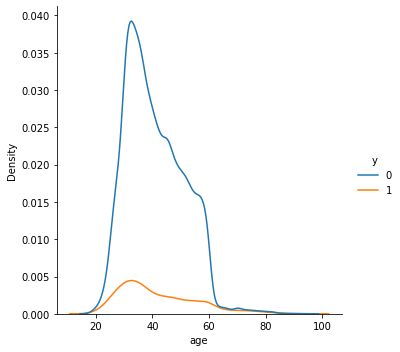

In [9]:
sns.displot(data = data, x = 'age', hue = 'y', legend = True, kind = 'kde')

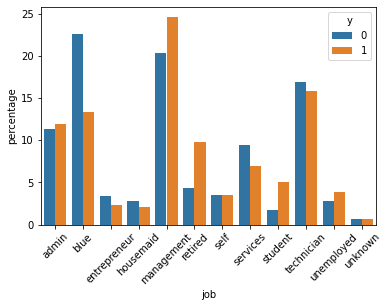

In [10]:
a = data.groupby('y')['job'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
g = sns.barplot(x = 'job', y = 'percentage', hue = 'y', data = a)
g.set_xticklabels(g.get_xticklabels(), minor = False, rotation = 45);

In [11]:
job_mas_comun = data.job.mode()
job_mas_comun[0]
data['job'] = data.job.apply(lambda x: job_mas_comun[0] if x == 'unknown' else x)

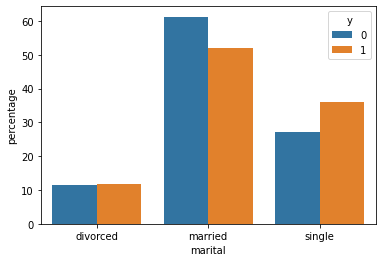

In [12]:
a = data.groupby('y')['marital'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'marital', y = 'percentage', hue = 'y', data = a)

Se observa claramente que los solteros y los divorciados tienen una tendencia superior a realizar depósitos en plazo fijo mayor a los casados

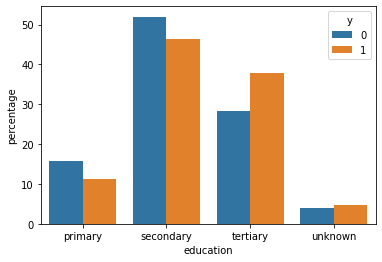

In [13]:
a = data.groupby('y')['education'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'education', y = 'percentage', hue = 'y', data = a)

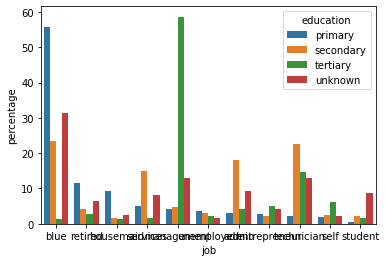

In [14]:
a = data.groupby('education')['job'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'job', y = 'percentage', hue = 'education', data = a)

In [15]:
tabla = data.groupby('job')['education'].agg(lambda x: x.value_counts().index[0])

for i in range(0, data.shape[0]-1):
  if data.education[i] == 'unknown':
    for j in range(0, tabla.shape[0]-1):
      if data.job[i] == tabla.index[j]:
        data.education[i] = tabla[j]

data['education'] = data.education.apply(lambda x: np.NaN if x == 'unknown' else x)
data.education.dropna(inplace=True)

A priori parece algo razonable pensar que las personas con mayor nivel educativo son mas propensos a realizar depósitos a plazo fijo, tal vez pueda ser que su excedente monetario sea mayor que en el resto de los casos o porque tienen mayor educación financiera. Se ven un pequeño porcentaje de *unkowns* que representan valores nulos y deberíamos imputarlos o removerlos

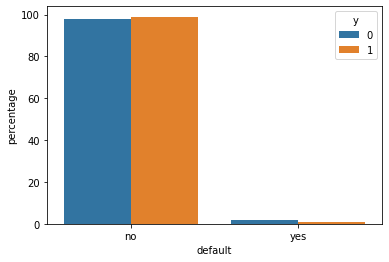

In [16]:
a = data.groupby('y')['default'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'default', y = 'percentage', hue = 'y', data = a)

Resulta bastante lógico pensar que los casos con default crediticio ni siquiera sean contactados para ofrecerles un plazo fijo, y que en caso de sean contactados, la tasa de aceptación sea menor

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


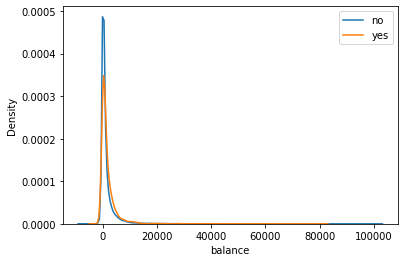

In [17]:
sns.distplot(data[data.y == 0].balance, hist = False, norm_hist= True, label = "no")
sns.distplot(data[data.y == 1].balance, hist = False, norm_hist= True, label = "yes")
plt.legend()

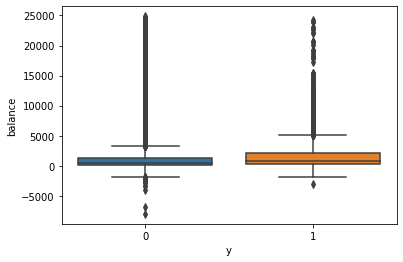

In [18]:
sns.boxplot(x = data.y, y = (data[data.balance < 25000].balance))

Aca vamos a tener que trabajar un poco sobre los outliers, ya que hay valores muy extremos. Dado que se trata de los saldos de cuentas bancarias otra buena posibilidad sería transformar la variable con un *ln* para normalizarla

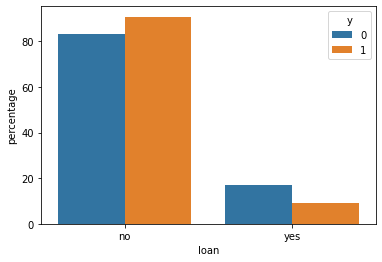

In [19]:
a = data.groupby('y')['loan'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'loan', y = 'percentage', hue = 'y', data = a)

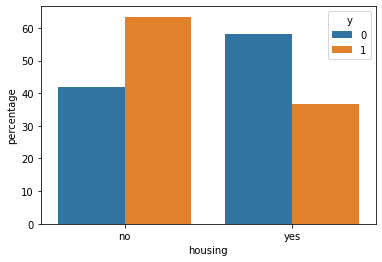

In [20]:
a = data.groupby('y')['housing'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'housing', y = 'percentage', hue = 'y', data = a)

Esta claro que aquellos usuarios que no tienen prestamos personales o hipotecarios son mas propensos a realizr un depósito en plazo fijo que aquellosq ue tienen deudas que saldar a fin de mes

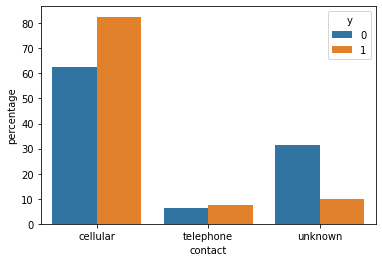

In [21]:
a = data.groupby('y')['contact'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'contact', y = 'percentage', hue = 'y', data = a)

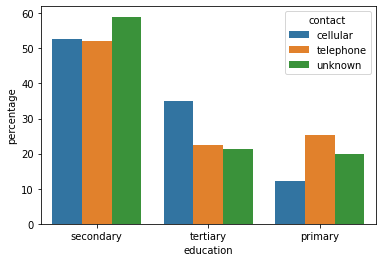

In [22]:
a = data.groupby('contact')['education'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'education', y = 'percentage', hue = 'contact', data = a)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

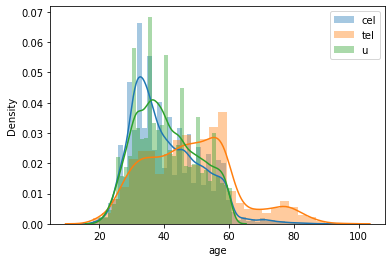

In [23]:
sns.distplot(data[data.contact == 'cellular'].age, label= 'cel')
sns.distplot(data[data.contact == 'telephone'].age, label = 'tel')
sns.distplot(data[data.contact == 'unknown'].age, label = 'u')
plt.legend()

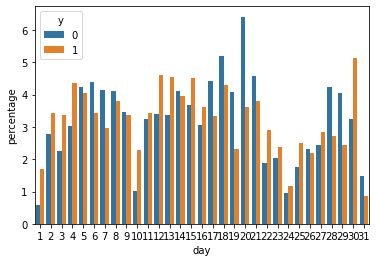

In [25]:
a = data.groupby('y')['day'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'day', y = 'percentage', hue = 'y', data = a)
sns.set(rc={'figure.figsize':(16,8.27)})

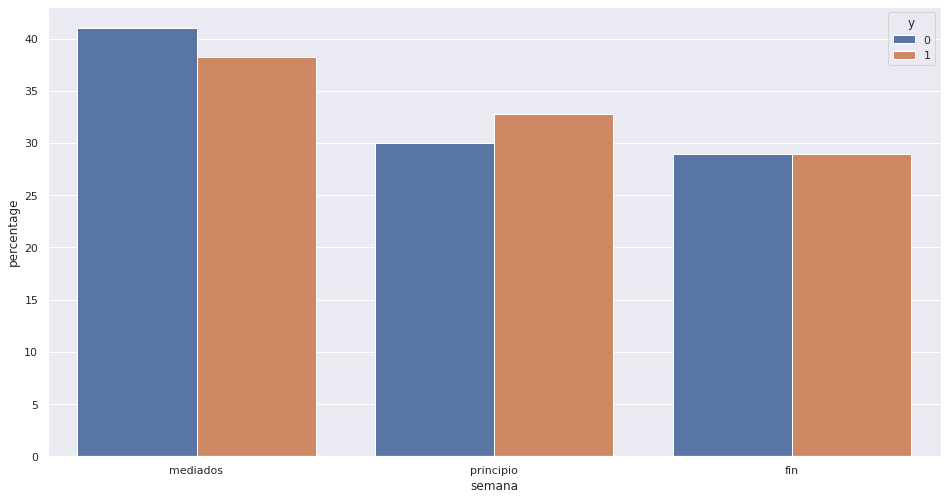

In [26]:
data['semana'] = data.day.apply(lambda x: 'principio' if x <= 10 else ('mediados' if ((x > 10) and (x <= 20)) else 'fin'))
a = data.groupby('y')['semana'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'semana', y = 'percentage', hue = 'y', data = a)
sns.set(rc={'figure.figsize':(11.7,8.27)})

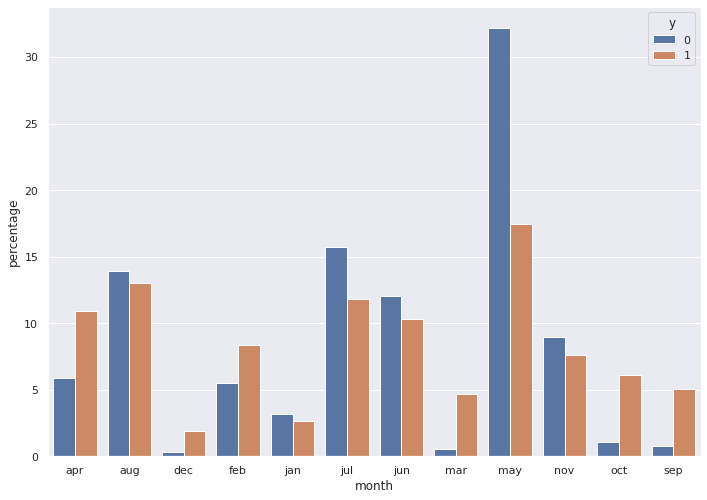

In [27]:
a = data.groupby('y')['month'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'month', y = 'percentage', hue = 'y', data = a)

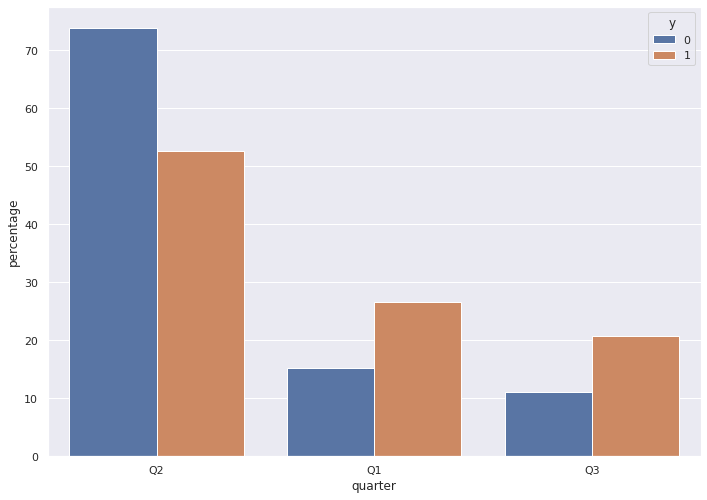

In [28]:
data['quarter'] = data.month.apply(lambda x: 'Q1' if x in ['jan', 'feb', 'mar', 'apr'] else ('Q2' if x in ['may', 'jun', 'jul', 'aug'] else 'Q3'))
a = data.groupby('y')['quarter'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'quarter', y = 'percentage', hue = 'y', data = a)

Se ve que los contactos tienen un efecto positivo al principio y al final del año, mientras que en el cuatrimestre intermedio las personas tienen una menor tendencia a realizar depósitos, tal vez por mayor incertidumbre respecto a lo que podría suceder con sus ahorros

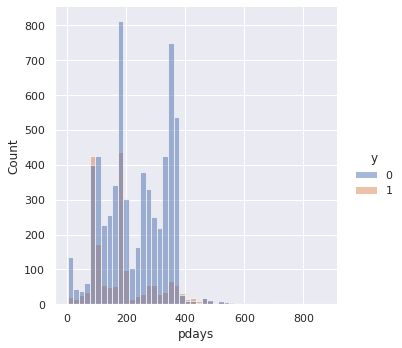

In [29]:
sns.displot(x = 'pdays', hue = 'y', data = data[data.pdays > -1])

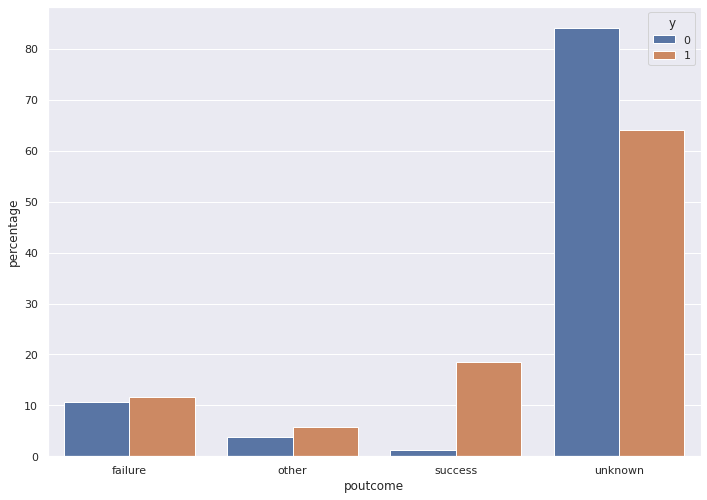

In [30]:
a = data.groupby('y')['poutcome'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'poutcome', y = 'percentage', hue = 'y', data = a)

In [31]:
data['poutcome'] = data.apply(lambda x: 'sin contacto' if x['pdays'] == -1 else x['poutcome'], axis = 1)
data['poutcome'] = data.poutcome.apply(lambda x: np.NaN if x == 'unknown' else x)
data.dropna(axis = 0, inplace = True)

In [32]:
other_per = data[(data.poutcome == 'success') | (data.poutcome == 'failure')].poutcome.value_counts() / data[(data.poutcome == 'success') | (data.poutcome == 'failure')].shape[0]

success = other_per[1]
fail = other_per[0]

In [33]:
data['poutcome'] = data.poutcome.apply(lambda x: np.NaN if x == 'other' else x)
data['poutcome'] = data.poutcome.apply(lambda x: 'failure' if ((x is np.NaN) & (np.random.uniform() < fail)) else ('success' if x is np.NaN else x))

Ahora que ya tenemos mas o menos acomodadas las variables y entendemos como afecta cada una de ellas a la variable respuesta, podemos empezar a ver como interactuan entre ellas

In [35]:
data = data[data.balance < 50000]

# Modelado

In [53]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, Parallel, make_union
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [37]:
X = data.drop('y', axis = 1)
y = data.y

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [45]:
numeric_features = Pipeline([('column_selector', ColumnSelector(['age', 'balance'])),
                             ('scaler', StandardScaler())])

In [46]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.get_dummies(X[self.columns], columns = self.columns, drop_first = True)
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [47]:
categorical_features = Pipeline([('dummies', GetDummiesTransformer(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month']))])

In [48]:
procesador = Pipeline([('preprocessing', make_union(numeric_features, categorical_features)),
                       ('classifier', 'passthrough')])

In [49]:
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 332)

parametros = [
              {
                  'classifier': (GaussianNB(), )
              },
              {
                  'classifier': (LogisticRegression(),),
                  'classifier__C': np.linspace(0.01, 10, 50)
              },
              {
                  'classifier': (KNeighborsClassifier(),),
                  'classifier__n_neighbors': [i for i in range(10, 40)],
                  'classifier__weights': ['uniform', 'distance']
               },
              {
                  'classifier': (DecisionTreeClassifier(),),
                  'classifier__max_depth': [i for i in range(4,10)],
                  'classifier__min_samples_split': [10,25,50]
              }
              ]

grid_search = GridSearchCV(procesador, parametros, cv=cv, scoring = 'accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=332, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('pipeline-1',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('column_selector',
                                                                                         ColumnSelector(columns=['age',
                                                                                                                 'balance'])),
                                                                                        ('scaler',
                                                                                         St

In [50]:
print(grid_search.best_estimator_)
grid_search.best_score_

Pipeline(memory=None,
         steps=[('preprocessing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('column_selector',
                                                                  ColumnSelector(columns=['age',
                                                                                          'balance'])),
                                                                 ('scaler',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                          

0.8903688607182637

In [51]:
pd.DataFrame(classification_report(y_test, grid_search.predict(X_test), output_dict= True))

,0,1,accuracy,macro avg,weighted avg
precision,0.897731,0.636816,0.890693,0.767274,0.867286
recall,0.988909,0.147211,0.890693,0.568060,0.890693
f1-score,0.941117,0.239141,0.890693,0.590129,0.859205
support,13164.000000,1739.000000,0.890693,14903.000000,14903.000000


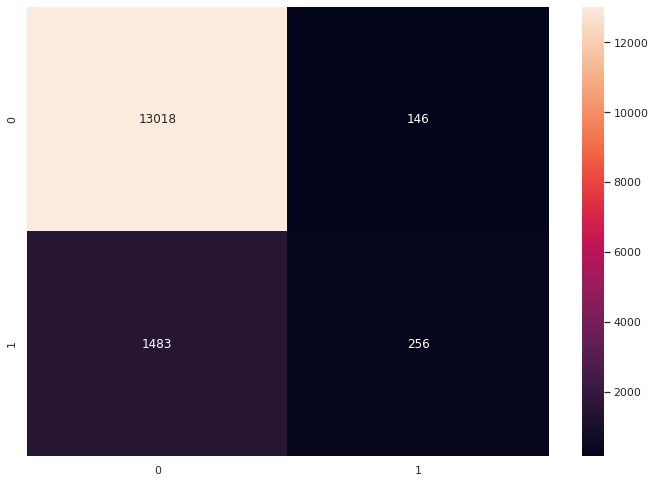

In [52]:
sns.heatmap(confusion_matrix(y_test, grid_search.predict(X_test)), annot= True, fmt ='.0f')